Train Loss: 0.641 	 Test Loss: 0.732
Train Loss: 0.618 	 Test Loss: 0.709
Train Loss: 0.601 	 Test Loss: 0.686
Train Loss: 0.587 	 Test Loss: 0.674
Train Loss: 0.577 	 Test Loss: 0.669
Train Loss: 0.564 	 Test Loss: 0.654
Train Loss: 0.551 	 Test Loss: 0.646
Train Loss: 0.542 	 Test Loss: 0.633
Train Loss: 0.534 	 Test Loss: 0.626
Train Loss: 0.532 	 Test Loss: 0.622
Train Loss: 0.526 	 Test Loss: 0.610
Train Loss: 0.524 	 Test Loss: 0.608
Train Loss: 0.520 	 Test Loss: 0.609
Train Loss: 0.518 	 Test Loss: 0.615
Train Loss: 0.513 	 Test Loss: 0.612
Train Loss: 0.514 	 Test Loss: 0.609
Train Loss: 0.507 	 Test Loss: 0.603
Train Loss: 0.511 	 Test Loss: 0.607
Train Loss: 0.510 	 Test Loss: 0.600
Train Loss: 0.504 	 Test Loss: 0.603
Train Loss: 0.504 	 Test Loss: 0.598
Train Loss: 0.505 	 Test Loss: 0.593
Train Loss: 0.502 	 Test Loss: 0.600
Train Loss: 0.503 	 Test Loss: 0.607
Train Loss: 0.507 	 Test Loss: 0.595
Train Loss: 0.499 	 Test Loss: 0.600
Train Loss: 0.503 	 Test Loss: 0.593
T

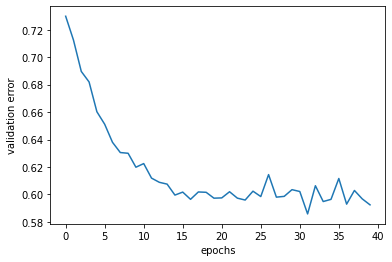

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as opt

import pandas as pd
import numpy as np
import math

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from matplotlib import pyplot as plt

def results (loader,network):
  accuracy = 0
  
  precision = 0

  for i, (X,y) in enumerate(loader):
    yHat = network(X)
    
    accuracy = accuracy + accuracy_score((y.detach().numpy()).astype('float64') ,yHat.detach().numpy().astype('float64'), normalize=True, sample_weight=None)              
    precision = precision + precision_score(y.detach().numpy(),yHat.detach().numpy(),  normalize=True, sample_weight=None)
    
    
  accuracy = accuracy / i
  precision = precision / i
  results_dict = {'accuracy': accuracy,'precision':precision}
  returnresults_dict


def training_graph(accuracy_list, precision_list):
  plt.plot(range(len(accuracy_list)), accuracy_list)
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.show()
  plt.plot(range(len(accuracy_list)), precision_list) 
  plt.xlabel("epochs")
  plt.ylabel("precision")
  plt.show()


class diabetes_detection(nn.Module):
  def __init__(self, input_size, output_size):
    super(diabetes_detection, self).__init__()
    self.linear = nn.Sequential(nn.BatchNorm1d(input_size),
                                nn.Linear(input_size, output_size),
                                torch.nn.Sigmoid())
    
  def forward(self, input):
    output = self.linear(input)
    return output



def train_dd(train_loader, valid_loader, alpha, epochs, network):
  acc_list = [] 
  pres_list = []
  optimizer = torch.optim.Adam(network.parameters(), lr = alpha)
  for epoch in range(epochs):
    epoch_loss = 0
    for i, (X,y) in enumerate(train_loader):
      yHat = network(X)
      loss = torch.nn.BCELoss()(yHat,y.reshape(-1,1))
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    acc_list.append(test_dd(valid_loader, network))
  
    print('Train Loss: %.3f \t Test Loss: %.3f'%(epoch_loss/i, test_dd(valid_loader, network)))
    #res = results (valid_loader,network)
    #acc_list.append(res['accuracy'])
    #pres_list.append(res['precision'])
  return acc_list

def test_dd(loader,network):
  epoch_loss = 0
  for i, (X,y) in enumerate(loader):
    yHat = network(X)
    loss = torch.nn.BCELoss()(yHat,y.reshape(-1,1))
    epoch_loss += loss.item()
  return epoch_loss/i

def test(data,network):
  error = 0
   
  for i, (X,y) in enumerate(data):
    yHat = network(X)
    if (y == 1 and yHat < 0.5) or (y == 0 and yHat >= 0.5):
      error = error + 1
  return error/len(data)
 

header = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
          'DiabetesPedigreeFunction', 'Age', 'Outcome']
##### I uploaded the diabetes csv to a public github so we can all load the file easily
url = 'https://raw.githubusercontent.com/ayshon/diabetes_dataset/master/diabetes.csv'
df1 = pd.read_csv(url)
dataset = np.array(df1)
np.random.seed(1000)

np.random.shuffle(dataset)
dataset_length = dataset.shape[0]

# split dataset into 70% training, 15% validation, and 15% testing
train_length = math.floor(dataset_length * 0.7)
valid_length = math.ceil(dataset_length * 0.15)
test_length = dataset_length - train_length - valid_length

x_train = torch.Tensor(dataset[:train_length,:-1])
x_valid = torch.Tensor(dataset[train_length: train_length + valid_length, :-1])
x_test = torch.Tensor(dataset[train_length + valid_length:, :-1])

y_train = torch.Tensor(dataset[:train_length, -1])
y_valid = torch.Tensor(dataset[train_length: train_length + valid_length, -1])
y_test = torch.Tensor(dataset[train_length + valid_length:, -1])

trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
testset = torch.utils.data.TensorDataset(x_test, y_test)


batch_size=50
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)

model = diabetes_detection(8,1)
#print(test_dd(train_loader,model))
valid_Error = train_dd(train_loader=train_loader, valid_loader=valid_loader, alpha=0.001, epochs=40, network=model)

plt.plot(range(40), valid_Error)
plt.ylabel("validation error")
plt.xlabel("epochs")
plt.show()
#print(test_dd(train_loader,model))
#print(test(train_loader,model))

Train Loss: 0.650 	 Test Loss: 0.748
Train Loss: 0.631 	 Test Loss: 0.724
Train Loss: 0.612 	 Test Loss: 0.705
Train Loss: 0.595 	 Test Loss: 0.689
Train Loss: 0.582 	 Test Loss: 0.671
Train Loss: 0.572 	 Test Loss: 0.660
Train Loss: 0.557 	 Test Loss: 0.646
Train Loss: 0.553 	 Test Loss: 0.649
Train Loss: 0.544 	 Test Loss: 0.639
Train Loss: 0.535 	 Test Loss: 0.630
Train Loss: 0.669 	 Test Loss: 0.753
Train Loss: 0.637 	 Test Loss: 0.727
Train Loss: 0.612 	 Test Loss: 0.706
Train Loss: 0.593 	 Test Loss: 0.682
Train Loss: 0.572 	 Test Loss: 0.666
Train Loss: 0.563 	 Test Loss: 0.650
Train Loss: 0.551 	 Test Loss: 0.640
Train Loss: 0.539 	 Test Loss: 0.638
Train Loss: 0.537 	 Test Loss: 0.621
Train Loss: 0.532 	 Test Loss: 0.623
Train Loss: 0.764 	 Test Loss: 0.862
Train Loss: 0.729 	 Test Loss: 0.834
Train Loss: 0.701 	 Test Loss: 0.806
Train Loss: 0.676 	 Test Loss: 0.780
Train Loss: 0.655 	 Test Loss: 0.757
Train Loss: 0.635 	 Test Loss: 0.734
Train Loss: 0.619 	 Test Loss: 0.725
T

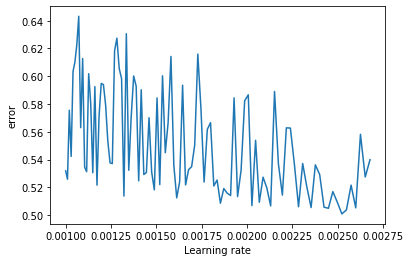

In [ ]:

error = []
rate = []
alpha = 0.001

for i in range(100):
  model = diabetes_detection(8,1)
  train_dd(train_loader=train_loader, valid_loader=valid_loader, alpha=alpha, epochs=10, network=model)
  error.append(test_dd(train_loader,model))
  rate.append(alpha)
  alpha = alpha*1.01

plt.plot(rate, error)
plt.xlabel("Learning rate")
plt.ylabel("error")
plt.show()